### Load selected rows

In [6]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
df = pd.read_csv('../data/3_selected/selected.csv')
df.describe()


,job_id,roast_amount_kg,1st_malt_amount_kg,2nd_malt_amount_kg,mt_temperature,mt_time,wk_temperature,wk_steam,wk_time,total_cold_wort,ph,extract,color,woc_time,whp_transfer_time,whp_rest_time,1st_malt_color,2nd_malt_color
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,2.449966e+09,40.364099,13708.801941,6518.586737,67.819929,6755.558000,105.240010,6715.525000,6776.986333,936.898333,5.622935,15.202680,17.741587,3101.783500,752.844000,14.495181,6.048667,6.019283
std,2.924662e+03,17.982047,1369.917810,1102.770677,2.861199,440.785944,0.636487,279.615828,588.860492,134.627923,0.744504,1.017336,9.645823,548.827876,59.693521,0.007603,0.081353,0.015237
min,2.449960e+09,17.415013,0.000000,3996.957605,66.866813,6458.600000,97.659771,6170.500000,5929.700000,68.800000,2.295564,6.796530,11.542656,107.500000,719.175000,14.476667,5.912500,5.912500
25%,2.449963e+09,24.778737,13944.859845,6068.565933,66.909513,6620.387500,105.202896,6568.250000,6554.275000,954.600000,5.547247,15.148521,12.892941,3123.950000,729.925000,14.494583,6.020000,6.020000
50%,2.449966e+09,28.272487,14041.300940,6074.067303,67.002759,6700.475000,105.269124,6654.250000,6665.000000,963.200000,5.625450,15.391154,13.418677,3143.837500,736.375000,14.494583,6.020000,6.020000
75%,2.449968e+09,64.177513,14087.302593,6160.225824,67.208414,6773.575000,105.373703,6802.062500,6807.437500,968.575000,5.743791,15.551699,14.864908,3171.250000,743.900000,14.494583,6.127500,6.020000
max,2.449971e+09,88.042526,16092.750000,8434.826355,81.452861,11671.275000,105.718793,8202.250000,12621.575000,1088.975000,7.382991,16.320075,44.990000,4876.200000,1241.625000,14.584167,6.127500,6.127500


### Load features from dropped columns (product, date_time)
- day of week has moderate positive correlation (pearson)
- day of month has high correlation with 1st malt color (pearson, spearman)
- last_was_hnk and shift have some correlation to feature (spearman)


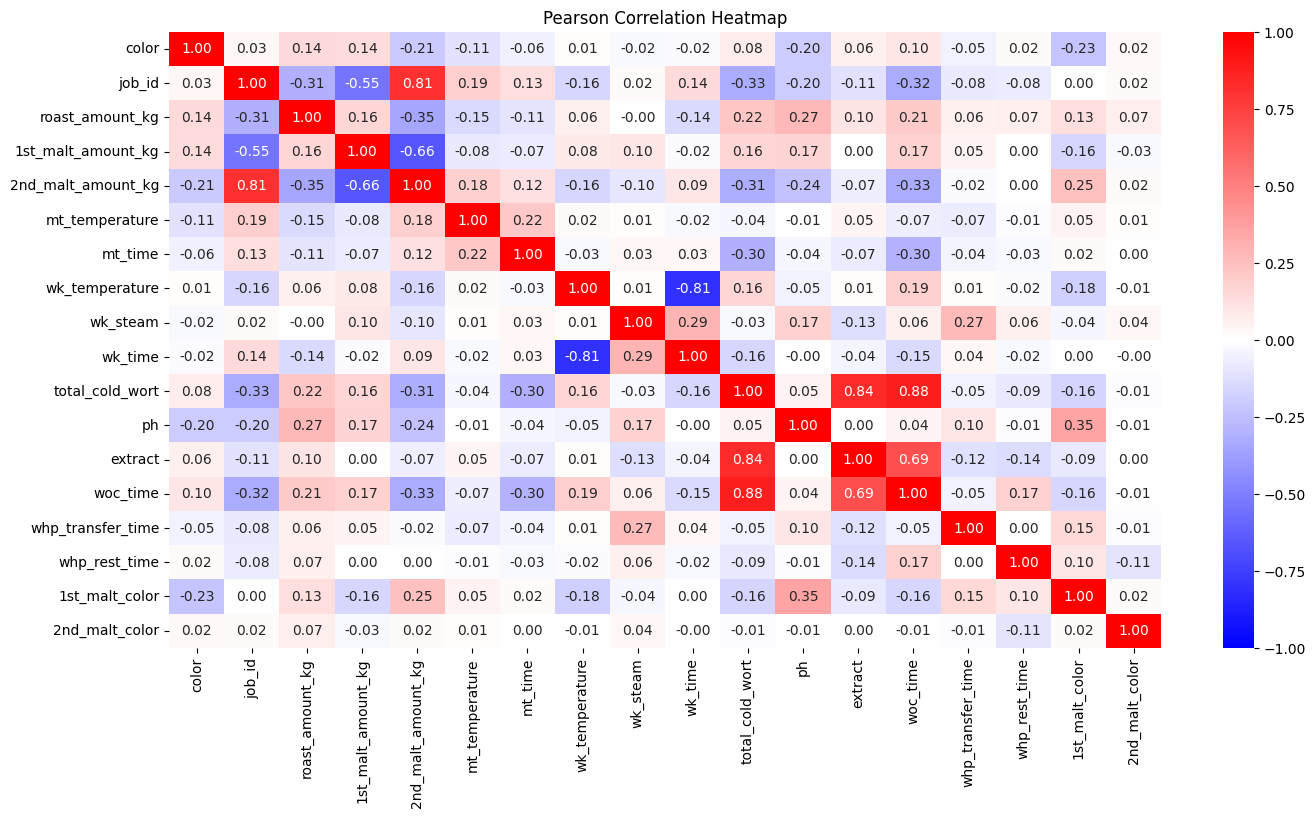

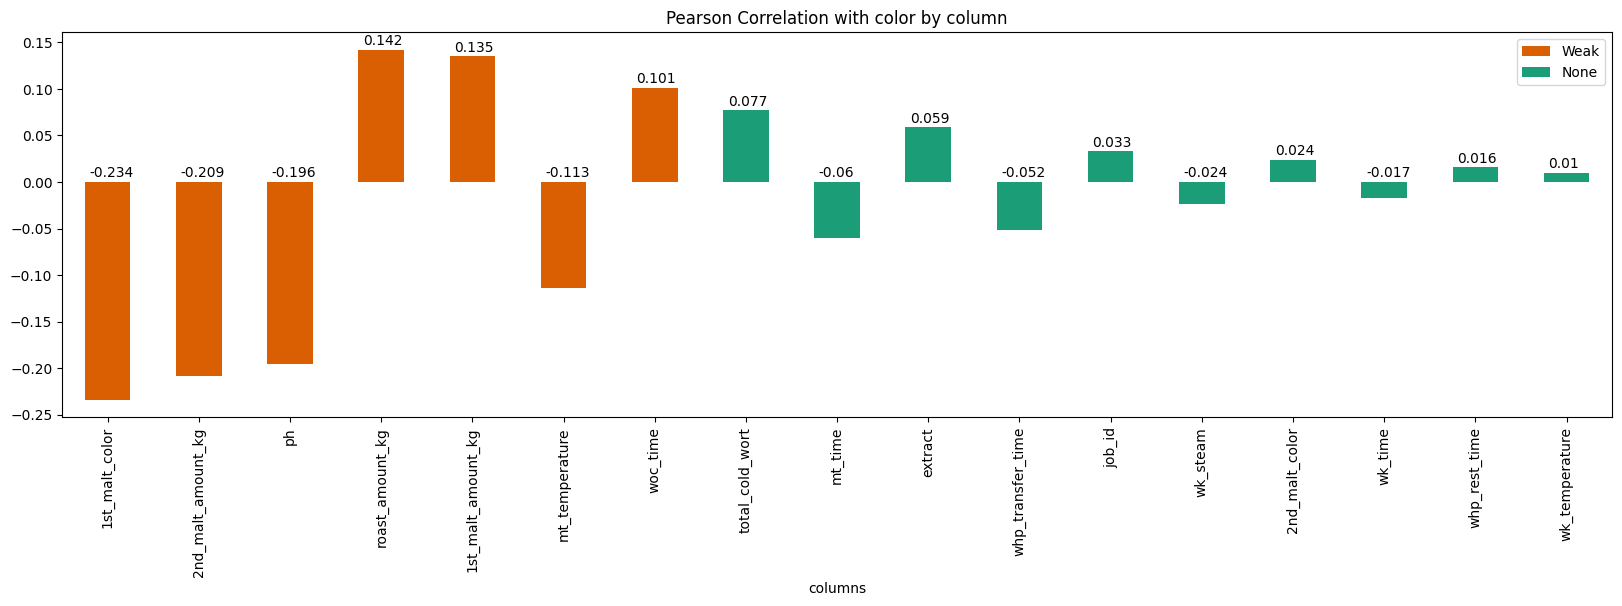

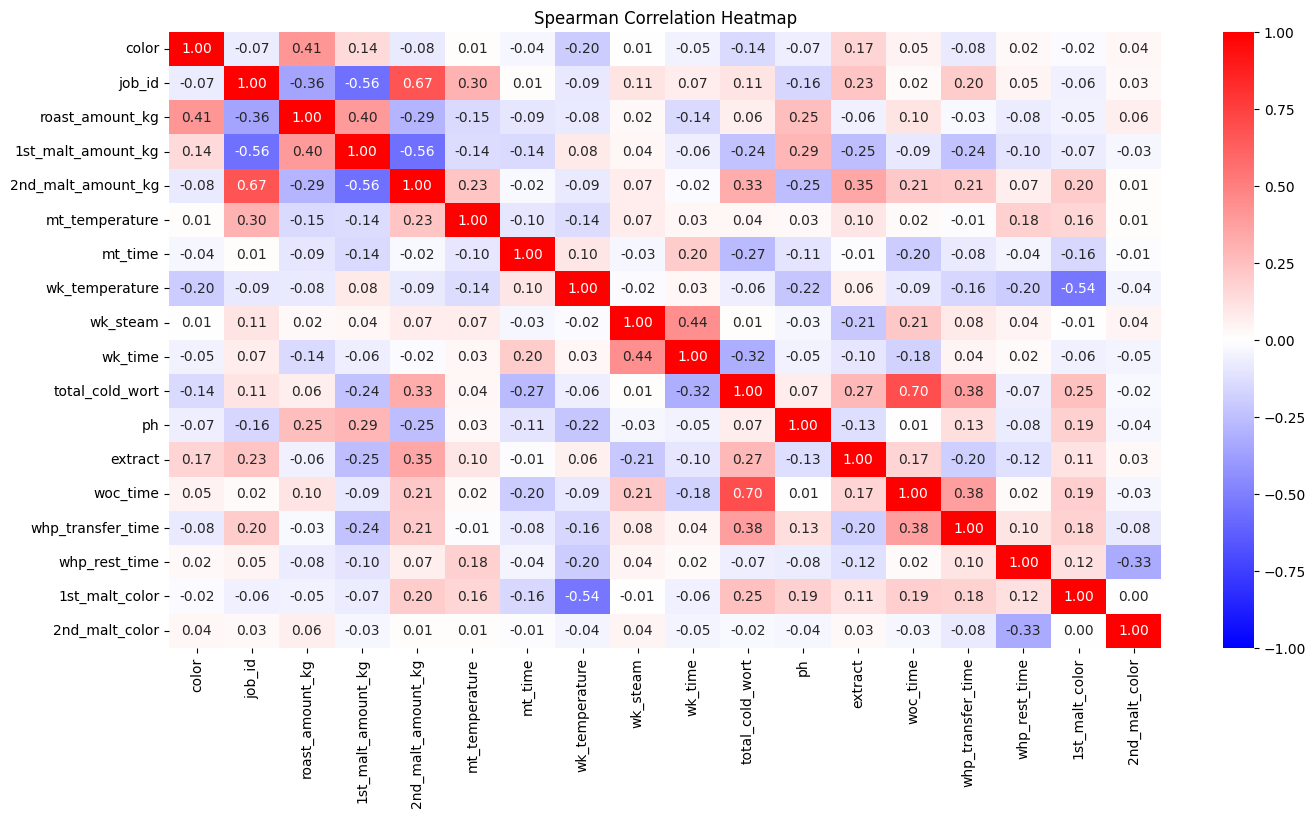

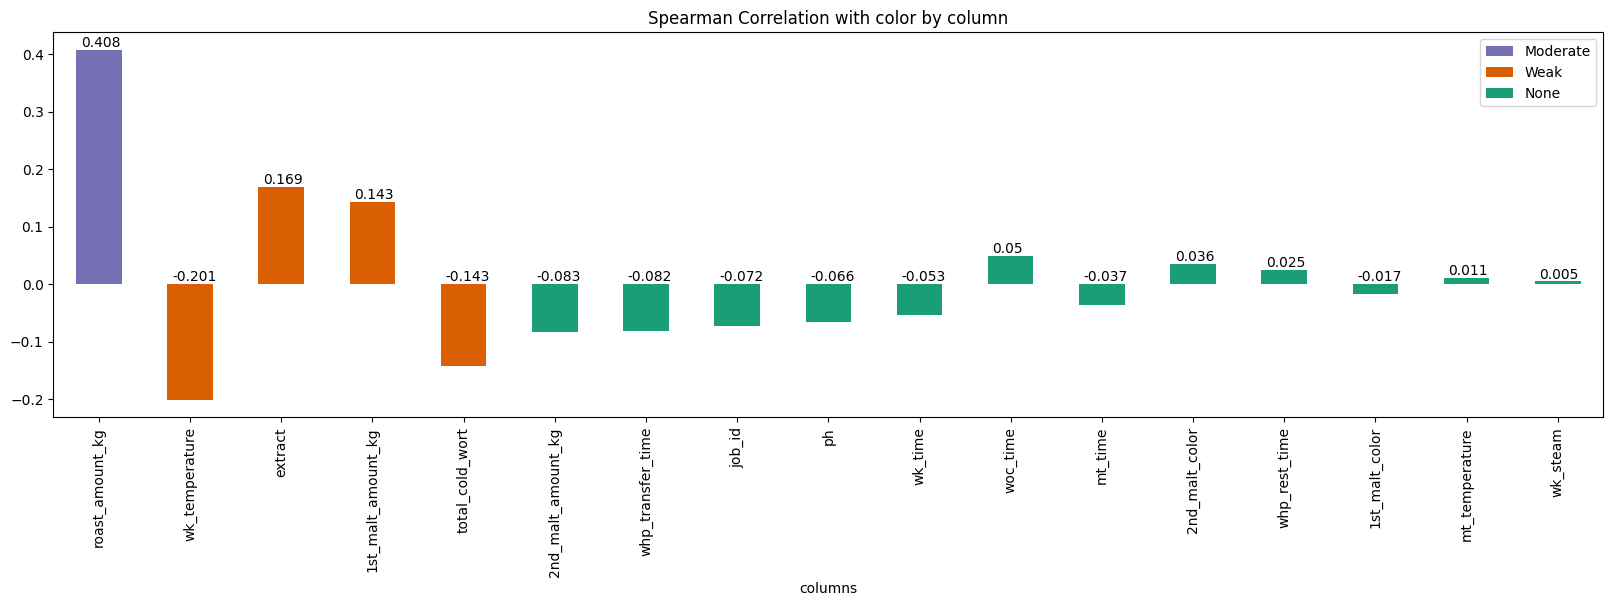

In [7]:
from src.load import dropped_columns_features
from src.corr import plot_correlation_bars
import seaborn as sns
import matplotlib.pyplot as plt


# df = df.merge(dropped_columns_features(), on='job_id').drop('job_id',axis=1)

method = ['pearson', 'spearman']
for m in method: 
    plt.figure(figsize = (16,8))
    cols = ['color'] + [i for i in df.columns if i != 'color']
    corr = df[cols].corr(m)
    ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=corr.values, fmt='.2f', cmap='bwr')
    ax.set(title=f'{m.title()} Correlation Heatmap')
    plot_correlation_bars(df, 'color', m)


### New features to check variable interaction
logging, squaring and taking square root of variables did not have any improments 

Proceeed to combinate columns using functions, and then picked some that had the best variations and considering with they were already used in other picked combination or not


<Axes: title={'center': 'Spearman Correlation with color by column'}, xlabel='columns'>

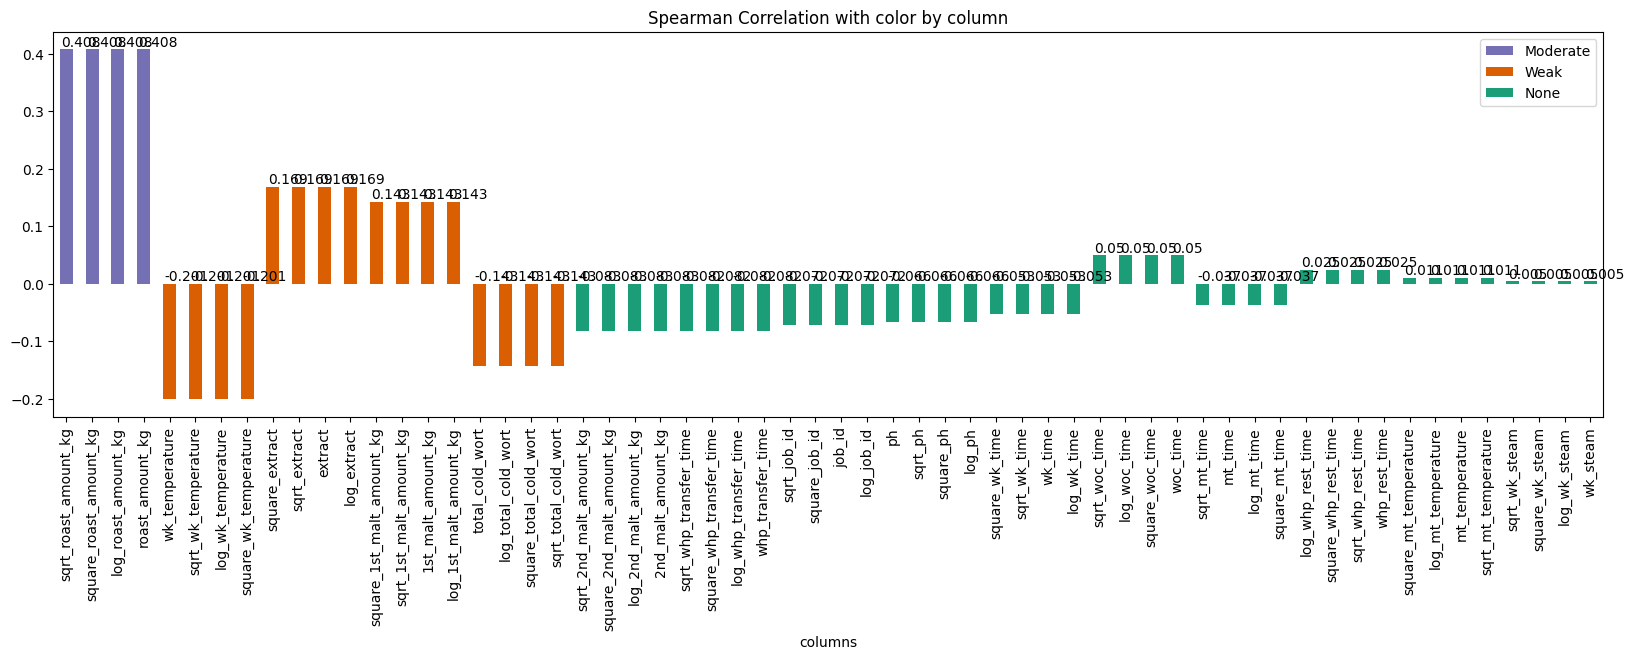

In [8]:
from typing import Callable
from itertools import combinations
import math

def multiply(a, b): return a*b

def divide(a, b): return a/(b+1) 
    
def foo(a, b): return (a*b)/(a+b)

def square(x): return x*x


def create_feature(df:pd.DataFrame, funcs:list[Callable]):
    _df = df.copy() 
    def asd(f, x):
        try: return f(x)
        except: return 0
    for c in _df.columns:
        for f in funcs:
            
            _df = _df.assign(**{f'{f.__name__}_{c}': df[c].apply(lambda x:  asd(f,x))})
    return _df

def create_feature2(df:pd.DataFrame, funcs:list[Callable]):
    _df = df.copy() 
    _combinations = list(combinations([i for i in df.columns if i != 'color'], 2))
    for c in _combinations:
        for f in funcs:
            _df = _df.assign(**{f'{f.__name__}__{c[0]}__{c[1]}': df.apply(lambda row: f(row[c[0]], row[c[1]]), axis=1)})
    return _df

a = create_feature(df, funcs=[math.log, square, math.sqrt])
plot_correlation_bars(a[[i for i in a.columns if '_color' not in i]], 'color', m)


### try to combine features to see if correlations improve
roast amount combination were filtered, it was the best correlation so no need to increase complexity in this one

In [9]:
from IPython.display import clear_output
b = create_feature2(df, funcs=[multiply, divide, foo])
clear_output()

In [10]:


def new_features_corr(df:pd.DataFrame, method:str):
  return (df.corr(method)['color'].to_frame(method)
            .abs()
            .sort_values(method, ascending=False)
            .reset_index(names='columns')
            )
spearman_nf = new_features_corr(b, 'spearman')
pearson_nf = new_features_corr(b, 'pearson')
nf_corr = spearman_nf.merge(pearson_nf, on ='columns')
original_corr = nf_corr.iloc[:, :3]
nf_corr = (nf_corr.query('columns.str.contains("__")')
                  .assign(function=nf_corr['columns'].str.split("__").str[0])
                  .assign(first_feature=nf_corr['columns'].str.split("__").str[1])
                  .assign(second_feature=nf_corr['columns'].str.split("__").str[2]))
nf_corr = (nf_corr.merge(original_corr, right_on='columns', left_on='first_feature', suffixes=('', '_first'))
                  .merge(original_corr, right_on='columns', left_on='second_feature', suffixes=('', '_second'))
           )

nf_corr = (nf_corr.assign(first_best=nf_corr.apply(lambda row: row['spearman_first'] if row['spearman_first']>row['pearson_first'] else row['pearson_first'], axis=1))
                  .assign(second_best=nf_corr.apply(lambda row: row['spearman_second'] if row['spearman_second']>row['pearson_second'] else row['pearson_second'], axis=1)))

nf_corr = (nf_corr.assign(previous_best=nf_corr.apply(lambda row: row['first_best'] if row['first_best']>row['second_best'] else row['second_best'], axis=1))
                  .assign(best=nf_corr.apply(lambda row: row['spearman'] if row['spearman']>row['pearson'] else row['pearson'], axis=1))
                  .rename({i: f'new_{i}' for i in ['spearman', 'pearson']}, axis=1)
                  )

nf_corr = nf_corr.assign(delta=nf_corr.apply(lambda row: row['best'] - row['previous_best'], axis=1)).sort_values('delta', ascending=False)


(nf_corr[['columns', 'best', 'previous_best', 'delta','function', 'first_feature','first_best', 'second_feature', 'second_best']]

 .query('~columns.str.contains("roast_amount")')
 .head(30)
 .reset_index(drop=True)

 )
keep = ['divide__total_cold_wort__woc_time', 'multiply__1st_malt_amount_kg__extract', 'multiply__2nd_malt_amount_kg__ph', 'divide__woc_time__whp_transfer_time',
        'multiply__whp_rest_time__2nd_malt_color', 'multiply__mt_time__wk_time']

# b is selected df + new engineered features 
b = b[list(df.columns) + keep]
b.to_csv('../data/4_engineered/engineered_features.csv', index=False)